### Deep Learning Miniproject - Audio

AVS 8th Semester - Group 841

In [37]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

import IPython.display as ipd

import librosa
import librosa.display

import torch
from torch import nn
from transformers import ASTFeatureExtractor
from torch.utils.data import random_split, DataLoader, Dataset
import pytorch_lightning as pl
import torchaudio as ta

#### 1. Explore the dataset through code

a. How many samples does the dataset contain?

In [47]:
#Load the data!
PATH = "./data/metadata_compiled.csv"
df = pd.read_csv(PATH)

#Check no. samples
print(f'Number of samples : {df.shape[0]}')

Number of samples : 27550


b. How many classes? How many samples per class? Show a histogram of the number of intances per class

In [11]:
print(f'Number of classes: {len(df["status"].unique())}.\n\
    Classes: {df["status"].unique()}\n\
    {pd.value_counts(df["status"], dropna=False)}')

Number of classes: 4.
    Classes: [nan 'healthy' 'COVID-19' 'symptomatic']
    healthy        12479
NaN            11326
symptomatic     2590
COVID-19        1155
Name: status, dtype: int64


In [100]:
classes = list(df["status"].unique())
inst_num = list(pd.value_counts(df['status'], dropna=False))

plot_df = pd.DataFrame({"class": classes, "inst_num" : inst_num})
plot_df

,class,inst_num
0,NaN,12479
1,healthy,11326
2,COVID-19,2590
3,symptomatic,1155


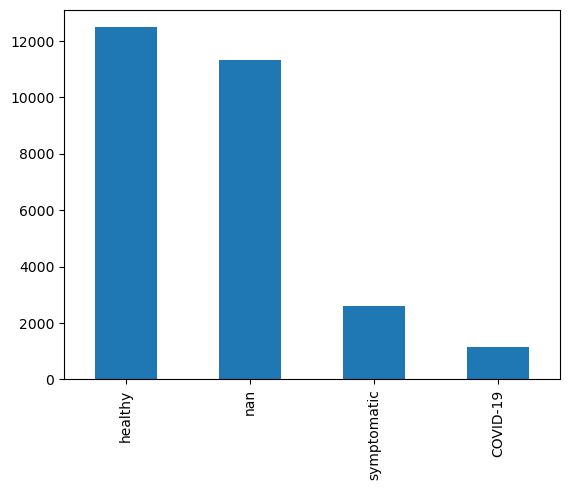

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [13]:
# some problem with this shit
pd.value_counts(df['status'], dropna=False).plot.bar()
plt.show()

c. Play a random sample from each class

In [14]:
# playing healthy
healthy = df[df['status'] == 'healthy'].sample()['uuid'].item()
path = "./conv/" + healthy + '.mp3'
y, sr = librosa.load(path)
ipd.Audio(y, rate=sr)

In [10]:
# playing COVID-19
covid = df[df['status'] == 'COVID-19'].sample()['uuid'].item()
path = "./conv/" + covid + '.mp3'
y, sr = librosa.load(path)
ipd.Audio(y, rate=sr)

In [12]:
# playing symptomatic
symptomatic = df[df['status'] == 'symptomatic'].sample()['uuid'].item()
path = "./conv/" + symptomatic + '.mp3'
y, sr = librosa.load(path)
ipd.Audio(y, rate=sr)

d. Describe if/how you think the data distribution will affect training of a classifier

e. Decide what part of the dataset to use; all, some classes, some samples. Motivate your choice

#### 2. Use a neural network of your own chose to classify the dataset. Explain your choice and at least one alternative. Document your experiences:.

#### Audio Spectogram Transformer Implementation

In [15]:
df_copy = df.copy()
df_copy = list(df_copy[pd.notna(df_copy['status'])]['status'])

A Dataset class is created to load the dataset

In [72]:
class AudioDatatset(Dataset):
    def __init__(self, audio_dir, class_csv):
        self.audio_dir = audio_dir
        self.class_csv = class_csv

        self.audio_dir_list = os.listdir(self.audio_dir)

    def __len__(self):
        return len(self.audio_dir_list)
    
    def __getitem__(self, idx):
        audio_file_path = os.path.join(self.audio_dir, self.audio_dir_list[idx])
        print("lol: l, self.audio_dir_list[idx]: ", self.audio_dir_list[idx])
        waveform, sample_rate = ta.load(audio_file_path, normalize=True)
        print(audio_file_path)
        #Transform 
        #Spectogram
        
        #Load csv file
        print("Path to csv", self.class_csv)
        df = pd.read_csv(self.class_csv)
        
        #print(df.head())

        

        return waveform, 

test = AudioDatatset('./conv/', "./data/metadata_compiled.csv")
print(test.__getitem__(0))

lol: l, self.audio_dir_list[idx]:  00039425-7f3a-42aa-ac13-834aaa2b6b92.mp3
./conv/00039425-7f3a-42aa-ac13-834aaa2b6b92.mp3
Path to csv ./data/metadata_compiled.csv
(tensor([[0., 0., 0.,  ..., 0., 0., 0.]]),)


In [28]:
class DataModuleClass(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        #self.transform = transforms.MelSpectrogram(sample_rate)
        self.batch_size = 12
        self.tensor_list = []
        self.class_list = []
        self.audio_data_files = os.listdir('./conv/')[0:5]
        
        print("big list?", len(self.audio_data_files))
        #Define required parameters here
    
    def prepare_data(self):
        #print(self.audio_data_files.type())#oloop through audio_data_files
        for file in self.audio_data_files:
            waveform, sample_rate = ta.load('./conv/' + file)
            
            #print("Sound file: ", file)
            #file = filename.mp3
            
            self.tensor_list.append(waveform)
        print(self.tensor_list)
        self.class_list = list(df[pd.notna(df['status'])]['status'])[0:5]
        print(self.class_list)
        
        
        #Define steps that should be done
        #only on one GPU, like getting data

    def setup(self, stage=None):
        #Apply melSpectogram transform

        self.train_data, self.valid_data, self.test_data = random_split(self.tensor_list, [7,2,1], generator=torch.Generator().manual_seed(42))
        self.train_class, self.valid_class, self.test_class = random_split(self.class_list, [7,2,1], generator=torch.Generator().manual_seed(42))

        #Define steps that should be done on every GPU,
        #like splitting data, applying transform etc.

    def train_dataloader(self):
        return self.train_data, self.train_class
        #Return dataloader for training datahere

    def val_dataloader(self):
        return self.valid_data, self.valid_class
        #Retur   
    def test_dataloader(self):
        return self.test_data, self.test_class
    

In [22]:
class ASTModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        #setup up each layer
        #self.l1 = nn.Linear(28 * 28, 10)
        


    def forward(self, x):
        pass

    def training_step(self, batch, batch_idx):
        x, y = batch

    def configure_optimizers(self):
        pass

Training Model

In [70]:
# getting the labels for classification
labels = list(df["status"].unique()[1:])

label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

num_labels = len(id2label)

In [77]:
# AutoModelForAudioClassification
from transformers import ASTForAudioClassification, AutoModelForAudioClassification, TrainingArguments, Trainer

In [82]:
# model

# TODO : choose something, same as for feature exctractor
# maybe this: "MIT/ast-finetuned-audioset-10-10-0.4593"

model_checkpoint = "MIT/ast-finetuned-audioset-10-10-0.4593"
model_checkpoint2 = "facebook/wav2vec2-base"

model = ASTForAudioClassification.from_pretrained(
    model_checkpoint2,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
    #ignore_mismatched_sizes=True
)

You are using a model of type wav2vec2 to instantiate a model of type audio-spectrogram-transformer. This is not supported for all configurations of models and can yield errors.
c:\Users\Kata\anaconda3\envs\deepl\lib\site-packages\transformers\configuration_utils.py:375: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing ASTForAudioClassification: ['wav2vec2.encoder.layers.2.attention.out_proj.weight', 'wav2vec2.encoder.layers.6.final_layer_norm.weight', 'wav2vec2.encoder.layers.6.attention.k_proj.weight', 'wav2vec2.encoder.layers.3.attention.q_proj.weight', 'wav2vec2.encoder.layers.11.attention.v_proj.weight', 'wav2vec2.encoder.layers.2.attentio

In [ ]:
output_dir = "./output/"
epochs = 10
batchsize = 32 # training batchsize

In [ ]:
# https://huggingface.co/docs/transformers/v4.26.1/en/main_classes/trainer#transformers.TrainingArguments
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=epochs,
    load_best_model_at_end=True,
    metric_for_best_model='loss',
    save_total_limit=1, # limit the total amount of checkpoints, deletes older chps in output_dir
    per_device_train_batch_size = batchsize,
    per_device_eval_batch_size = batchsize,
    logging_steps=500,
)
#report_to="tensorboard",

#optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, warmup_cosine(100,max_lr=lr,total_steps=total_steps, optimizer_lr=lr,min_lr=1e-6))

In [ ]:
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
trainer = Trainer(
    model,
    training_args,
    train_dataset= None, # TODO
    eval_dataset=None, # TODO
    #tokenizer=feature_extractor, TODO
    compute_metrics=compute_metrics,
    #optimizers=(optimizer, scheduler)
)

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

a. Discuss at least four relevant hyper-parameters

b. Experiment with the effect of different batch sizes

c. Experiment with the effect of different learning rates

d. Experiment with different number of network layers

e. Implement at least two data agumentation techniques

f. Discuss what influences the memory use of a solution such as yours. What can be done to reduce this?